In [134]:
import numpy as np
from sklearn.metrics import euclidean_distances
import pandas as pd
from minisom import MiniSom
import LVQ
from pylab import bone, pcolor, colorbar, plot, show

In [135]:
data = pd.read_csv(r"../data/SD-2X_rocktype.csv")
x = data.iloc[:, 0:6].values
y = data.iloc[:, 6].values
y[y==4] = 0
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=44)

# use Minmaxscaler because we use euclidean distance
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

In [136]:
# Training the SOM
som = MiniSom(x = 10, y = 10, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(x_train)
som.train_random(data = x_train, num_iteration = 100)

In [137]:
labels = np.zeros((4, 10, 10))
propa = np.zeros((4, 10, 10))

In [138]:
labels.shape[1]

10

In [139]:
# Visualizing the results
def visualSom(x_train, y_train, som):
    numLabels = len(np.unique(y_train))
    labels = np.zeros((numLabels, som.x, som.y))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['v', 's', 'o', '4']
    colors = ['r', 'g', 'b', 'y']
    for i, x in enumerate(x_train):
        w = som.winner(x)
        plot(w[0] + 0.5,
             w[1] + 0.5,
             markers[y_train[i]],
             markeredgecolor = colors[y_train[i]],
             markerfacecolor = 'None',
             markersize = 10,
             markeredgewidth = 2)
        for nl in range(numLabels):
            if y_train[i] == nl:
                labels[nl, w[0], w[1]] += 1
    show()
    return labels

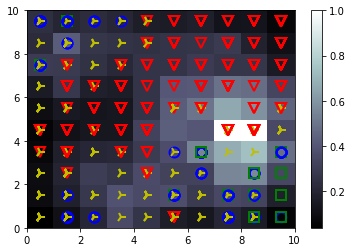

In [140]:
labels = visualSom(x_train=x_train, y_train=y_train, som=som)

In [141]:
def propabilitySom(labels):
    propa = np.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
#                 total = labels[0, j, k] + labels[1, j, k] + labels[2, j, k] + labels[3, j, k]
                total = sum(labels[i, j, k] for i in range(labels.shape[0]))
                if total == 0. :
                    continue
                else:
                    propa[i, j, k] = labels[i, j, k] / total
                    propa[i, j, k] = round(propa[i, j, k], 2)
    return propa

In [142]:
propa = propabilitySom(labels)

In [143]:
p_vectors = som.weights

In [144]:
def taggingSom(labels):
    x = labels.shape[1]
    y = labels.shape[2]
    tag = labels.shape[0]
    taggings = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            tmp = np.array([labels[t][i][j] for t in range(tag)])
            sort = tmp.argsort()
            if (tmp[sort[tag-1]] <= tmp[sort[tag-2]] * 5): # must be improve
                taggings[i][j] = np.random.choice([sort[tag-1], sort[tag-2]])
            else:
                taggings[i][j] = sort[tag-1]
    return taggings

In [145]:
taggings = taggingSom(labels=labels)

In [146]:
def find_closest(in_vector, proto_vectors, labels):
    """
    Find the closest prototype vector for a given vector

    Parameters
    -------
    in_vector: the given vector
    proto_vectors: the set of prototype vectors
    """
    closest_distance = 99999
    x = labels.shape[1]
    y = labels.shape[2]
    for i in range(x):
        for j in range(y):
            if (sum(labels[k, i, j] for k in range(labels.shape[0])) == 0):
                continue
            else:
                distance = np.linalg.norm(in_vector - proto_vectors[i][j])
                if distance < closest_distance:
                    closest_distance = distance
                    closest = (i, j)         
    return closest

In [147]:
def predict(test_vector, p, taggings, labels):
    position = find_closest(test_vector, p, labels)
    return taggings[position[0], position[1]]

In [148]:
predicted_y1 = [predict(instance, p_vectors, taggings, labels) for instance in x_test]

from sklearn.metrics import classification_report

print (classification_report(y_test, predicted_y1, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.96      0.93      0.94        54
          1       0.93      0.57      0.70        23
          2       0.23      0.75      0.35         8
          3       0.85      0.72      0.78        47

avg / total       0.87      0.78      0.81       132



In [149]:
data_new = pd.read_csv(r"../data/SD-3X_rocktype.csv")
x_new = data.iloc[:, 0:6].values
y_new = data.iloc[:, 6].values
y_new[y_new == 4] = 0
x_new = minmax.fit_transform(x_new)
predicted_y_new = [predict(instance, p_vectors, taggings, labels) for instance in x_new]

from sklearn.metrics import classification_report

print (classification_report(y_new, predicted_y_new, target_names=['0', '1', '2', '3']))

             precision    recall  f1-score   support

          0       0.93      0.92      0.93       558
          1       0.81      0.75      0.78       165
          2       0.39      0.64      0.49       139
          3       0.82      0.69      0.75       453

avg / total       0.82      0.79      0.80      1315



# Next SOM

In [150]:
# Training the SOM
from minisom import MiniSom
som2 = MiniSom(x = 10, y = 10, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som2.random_weights_init(x_train)
som2.train_random(data = x_train, num_iteration = 100)

In [151]:
labels2 = np.zeros((4, 10, 10))
propa2 = np.zeros((4, 10, 10))

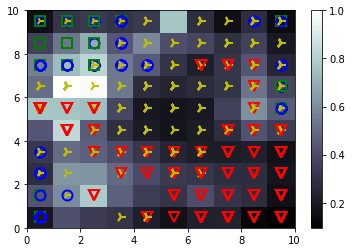

In [152]:
# Visualizing the results
labels2 = visualSom(x_train, y_train, som=som2)

In [153]:
propa2 = propabilitySom(labels2)

In [154]:
p_vectors2 = som2.weights

In [155]:
taggings2 = taggingSom(labels2)

In [156]:
predicted_y2 = [predict(instance, p_vectors2, taggings2, labels2) for instance in x_test]

from sklearn.metrics import classification_report

print (classification_report(y_test, predicted_y2, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96        54
          1       0.92      0.52      0.67        23
          2       0.17      0.50      0.26         8
          3       0.83      0.74      0.79        47

avg / total       0.86      0.78      0.81       132



# Next SOM

In [157]:
# Training the SOM
from minisom import MiniSom
som3 = MiniSom(x = 10, y = 10, input_len = 6, sigma = 1.0, learning_rate = 0.5)
som3.random_weights_init(x_train)
som3.train_random(data = x_train, num_iteration = 100)

In [158]:
labels3 = np.zeros((4, 10, 10))
propa3 = np.zeros((4, 10, 10))

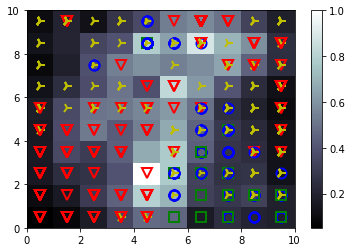

In [159]:
# Visualizing the results
labels3 = visualSom(x_train, y_train, som3)

In [160]:
propa3 = propabilitySom(labels3)

In [161]:
p_vectors3 = som3.weights

In [162]:
taggings3 = taggingSom(labels3)

In [163]:
predicted_y3 = [predict(instance, p_vectors3, taggings3, labels3) for instance in x_test]

from sklearn.metrics import classification_report

print (classification_report(y_test, predicted_y3, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.91      0.96      0.94        54
          1       0.90      0.78      0.84        23
          2       0.50      0.75      0.60         8
          3       0.91      0.83      0.87        47

avg / total       0.88      0.87      0.87       132



In [164]:
ensemble = [np.asarray(predicted_y1), np.asarray(predicted_y2), np.asarray(predicted_y3)]

In [165]:
predict = [np.bincount([ensemble[j][i] for j in range(3)]).argmax() for i in range(len(ensemble[1]))]

In [166]:
print (classification_report(y_test, predict, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.95      0.96      0.95        54
          1       0.88      0.61      0.72        23
          2       0.26      0.62      0.37         8
          3       0.88      0.79      0.83        47

avg / total       0.87      0.82      0.83       132



In [167]:
mapping = som.win_map(x_train)
mapping2 = som2.win_map(x_train)
mapping3 = som3.win_map(x_train)

In [168]:
result = np.array([])
for sample in x_test:
    pos1 = find_closest(sample, p_vectors, labels)
    pos2 = find_closest(sample, p_vectors2, labels2)
    pos3 = find_closest(sample, p_vectors3, labels3)
    l1 = len(mapping[pos1])
    l2 = len(mapping[pos2])
    l3 = len(mapping[pos3])
#     (pro1, pro2, pro3, pro4) = ((l1*propa[pos1]))
    pro1 = (l1*propa[0, pos1[0], pos1[1]] + l2*propa2[0, pos2[0], pos2[1]] + l3*propa3[0, pos3[0], pos3[1]])/(l1+l2+l3)
    pro2 = (l1*propa[1, pos1[0], pos1[1]] + l2*propa2[1, pos2[0], pos2[1]] + l3*propa3[1, pos3[0], pos3[1]])/(l1+l2+l3)
    pro3 = (l1*propa[2, pos1[0], pos1[1]] + l2*propa2[2, pos2[0], pos2[1]] + l3*propa3[2, pos3[0], pos3[1]])/(l1+l2+l3)
    pro4 = (l1*propa[3, pos1[0], pos1[1]] + l2*propa2[3, pos2[0], pos2[1]] + l3*propa3[3, pos3[0], pos3[1]])/(l1+l2+l3)
    tmp = np.argmax(np.array([pro1, pro2, pro3, pro4]))
    result = np.append(result, tmp)

In [169]:
from sklearn.metrics import classification_report

print (classification_report(y_test, result, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       1.00      0.94      0.97        54
          1       0.95      0.83      0.88        23
          2       0.50      0.50      0.50         8
          3       0.85      0.96      0.90        47

avg / total       0.91      0.90      0.90       132



In [170]:
data_new = pd.read_csv(r"../data/SD-3X_rocktype.csv")
x_new = data.iloc[:, 0:6].values
y_new = data.iloc[:, 6].values
y_new[y_new == 4] = 0
x_new = minmax.fit_transform(x_new)

In [171]:
result2 = np.array([])
for sample in x_new:
    pos1 = find_closest(sample, p_vectors, labels)
    pos2 = find_closest(sample, p_vectors2, labels2)
    pos3 = find_closest(sample, p_vectors3, labels3)
    l1 = len(mapping[pos1])
    l2 = len(mapping[pos2])
    l3 = len(mapping[pos3])
#     (pro1, pro2, pro3, pro4) = ((l1*propa[pos1]))
    pro1 = (l1*propa[0, pos1[0], pos1[1]] + l2*propa2[0, pos2[0], pos2[1]] + l3*propa3[0, pos3[0], pos3[1]])/(l1+l2+l3)
    pro2 = (l1*propa[1, pos1[0], pos1[1]] + l2*propa2[1, pos2[0], pos2[1]] + l3*propa3[1, pos3[0], pos3[1]])/(l1+l2+l3)
    pro3 = (l1*propa[2, pos1[0], pos1[1]] + l2*propa2[2, pos2[0], pos2[1]] + l3*propa3[2, pos3[0], pos3[1]])/(l1+l2+l3)
    pro4 = (l1*propa[3, pos1[0], pos1[1]] + l2*propa2[3, pos2[0], pos2[1]] + l3*propa3[3, pos3[0], pos3[1]])/(l1+l2+l3)
    tmp = np.argmax(np.array([pro1, pro2, pro3, pro4]))
    result2 = np.append(result2, tmp)

In [172]:
from sklearn.metrics import classification_report

print (classification_report(y_new, result2, target_names=['0','1', '2', '3']))

             precision    recall  f1-score   support

          0       0.97      0.95      0.96       558
          1       0.82      0.91      0.86       165
          2       0.77      0.51      0.61       139
          3       0.83      0.91      0.87       453

avg / total       0.88      0.88      0.88      1315

